# Think about Model Validation

## Model validation the wrong way

- naive approach to validation using the Iris data

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [3]:
model.fit(X, y)
y_model = model.predict(X)

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

### What is wrong?

- *it trains and evaluates the model on the same data*

## Model validation the right way: Holdout sets

- This splitting can be done using the `train_test_split` utility in Scikit-Learn
- The hold-out set is similar to unknown data

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

## Model validation via cross-validation

- One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training

- One way to address this is to use *cross-validation*

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

We could expand on this idea to use even more trials -> five-fold cross-validation

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

- train on all points but one in each trial -> *leave-one-out* cross validation

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
scores.mean()

0.96

## The Bias-variance trade-off

- "the best model" is about finding a sweet spot in the tradeoff between bias and variance

## Validation curves in Scikit-Learn

- y = ax$^3$ + bx$^2$ + cx + d
- We can generalize this to any number of polynomial featrues

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

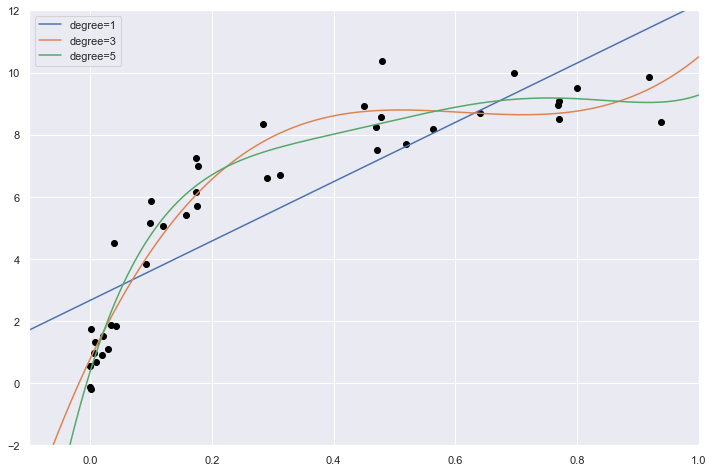

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]
figure = plt.figure(figsize=(12, 8))
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

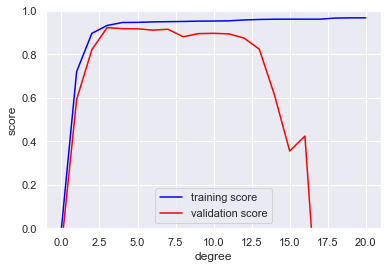

In [13]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

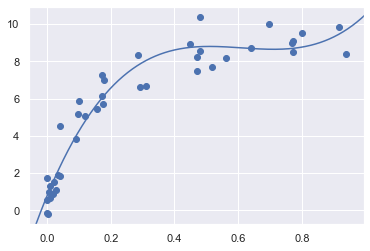

In [14]:
plt.scatter(X, y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test, y_test)
plt.axis(lim);

# Learning Curves

- One important aspect of model complexity is that the optimal model will generally depend on the size of your training data

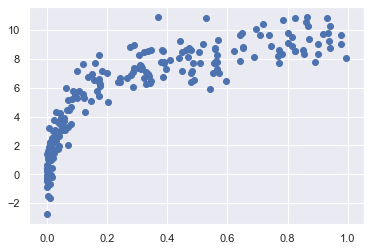

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

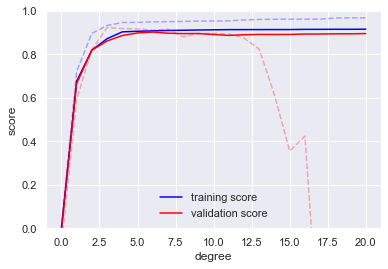

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='--')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='--')
plt.legend(loc='lower center', frameon=False)
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

## Learning curves in Scikit-Learn

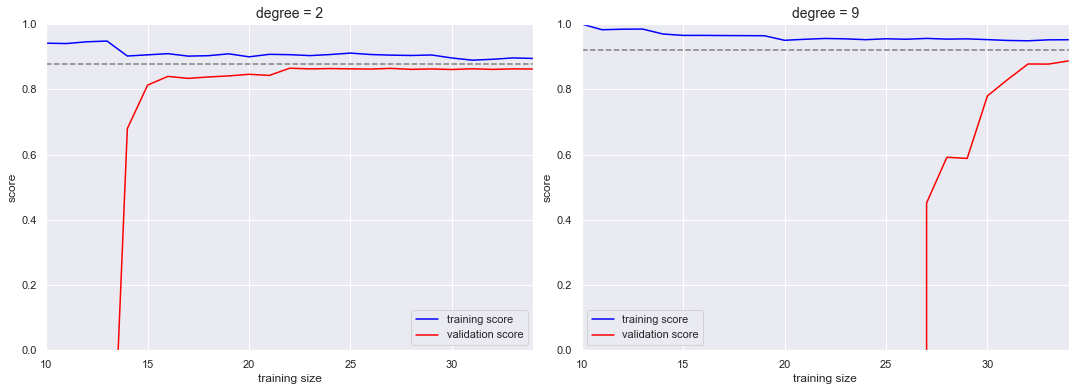

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree), 
                                         X, y, cv=7, train_sizes=np.linspace(0.3, 1, 25))
    
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='--')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

# Validation in Practice: Grid Search

- Here is an example of using grid search to find the optimal polynomial model
- This can be set up using Scikit-Learn's `GridSearchCV` meta-estimator

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [20]:
grid.fit(X, y);

C:\Users\imdff\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

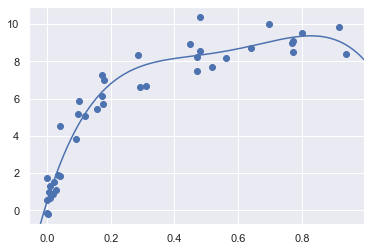

In [25]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim);